# Astrophysical Gamma-Ray Background

This notebook details how to construct the default astrophysical backgrounds in `GammaBayes` for use in Dark Matter parameter inference for CTA data from the Galactic Centre. The whole background for an analysis would require these components as well as a component for the rate/probability of mis-identified cosmic-rays. This is detailed further in the `prior_class`.

For now we split the astrophysical background into two components: the diffuse background and the localised source background. To get maps for the observed gamma ray spectra we then apply the effective area of the CTA. This notebook will detail how we can construct these maps with `GammaBayes`.

## Localised Source Emission Background

We start with the how we construct templates for the localised source emission around the galactic centre. Because these are source templates, within the overall framework we classify them as priors. Hence they are located within the `priors` modules of the package, specifically in the sub-module `astro_sources`. 

In [1]:
from gammabayes.priors import astro_sources

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Within this module we can access the models discussed within this tutorial. The relevant functions for the localised source emission are contained in the `construct_hess_source_map` and `construct_hess_source_map_interpolation` functions.

### `construct_hess_source_map`

The `construct_hess_source_map` function outputs the differential flux for the sources within 5 degrees of the Galactic Centre from the view of the CTA, meaning that we've applied the effective area of the telescope to the map. An example usage is as follows.

In [2]:
from gammabayes.utils.event_axes import energy_true_axis, longitudeaxistrue, latitudeaxistrue
from gammabayes.likelihoods.irfs import log_aeff

local_source_map = astro_sources.construct_hess_source_map(energy_axis=energy_true_axis, 
    longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue,
    log_aeff=log_aeff)

local_source_map.shape

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


(601, 35, 30)

The variable `local_source_map` now contains the differential flux map for these sources within the bounds of the sky position axes `longitudeaxis` and `latitudeaxis` and then evaluated over all the given axes. This gives a probability density matrix which we can visualise using `GammaBayes`s in-built plotting method `logdensity_matrix_plot` after taking the log of the matrix.

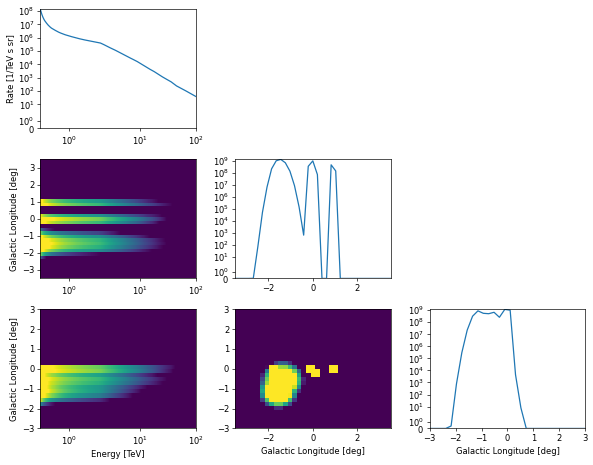

In [3]:
from gammabayes.utils.plotting import logdensity_matrix_plot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

fig,ax = logdensity_matrix_plot(axes=[energy_true_axis, longitudeaxistrue, latitudeaxistrue], 
                        log_dist_matrix=np.log(local_source_map),
                        axis_names=['Energy [TeV]', 'Galactic Longitude [deg]', 'Galactic Longitude [deg]'], 
                        norm=LogNorm(vmin=5e2, vmax=5e6), 
                        single_dim_yscales='symlog', single_dim_ylabel = 'Rate [1/TeV s sr]', figsize=(10,8), dpi=60)
ax[0,0].set_xscale('symlog')
ax[1,0].set_xscale('symlog')
ax[2,0].set_xscale('symlog')
plt.tight_layout()
plt.show()

One can then use this within `GammaBayes` by interpolating this map yourself, however we supply a helper function that implements a linear interpolation of the map, such as to decrease computation time called `construct_hess_source_map_interpolation`. An example implementation is below.

### `construct_hess_source_map_interpolation`

In [4]:
log_HESS_source_interpolator = astro_sources.construct_hess_source_map_interpolation(energy_true_axis=energy_true_axis, 
    longitudeaxistrue=longitudeaxistrue, latitudeaxistrue=latitudeaxistrue,
    log_aeff=log_aeff, normalise=True)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


The normalise function normalises the above flux map into a probability density to be used within `GammaBayes` statistical framework, however, this is often not required as many of the classes within the pipeline will normalise the given inputs when necessary anyway.

If you are having trouble with the inputs remember that you can inspect the function inputs with the use of the in-built python function `help`.

In [5]:
help(logdensity_matrix_plot) 

print("\n\n")
help(log_HESS_source_interpolator)

Help on function logdensity_matrix_plot in module gammabayes.utils.plotting:

logdensity_matrix_plot(axes, log_dist_matrix, truevals=None, sigmalines_1d=True, sigmas=range(0, 6), cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x1513eeea0>, contours2d=False, levels=array([0.99999627, 0.99966454, 0.988891  , 0.86466472, 0.39346934]), axis_names=None, suptitle='', suptitlesize=12, plot_density=False, norm=None, single_dim_yscales='symlog', single_dim_ylabel='', vmin=None, vmax=None, iteratable_logspace_integrator=<function iterate_logspace_integration at 0x14dae4680>, single_dim_logspace_integrator=<function logspace_riemann at 0x14dae44a0>, **kwargs)




Help on function <lambda> in module gammabayes.priors.astro_sources.localised_sources.hess_catalogue_sources:

<lambda> lambda energy, longitude, latitude
    # Then we make a wrapper to put the result of the function in log space



In every instance unless otherwise stated, `GammaBayes` works in 'TeV' for any energy measurements and Galactic Coordinates/'deg' for any sky position measurements. So if we want the log probability density for this map at 1 TeV at the Galactic Centre we do the following,

In [6]:
log_HESS_source_interpolator(1.0, 0.0, 0.0)

-5.3824665637396665

## Diffuse Emission Background

The other main astrophysical background that we consider by default is the diffuse astrophysical background. We use the Fermi LAT diffuse model available through `Gammapy` but modify the spectrum to match that of [Gaggero et al. (2017)](https://arxiv.org/pdf/1702.01124.pdf) specifically in the _pacman_ region. The two ways this map can be implemented are pretty much equiavlent to the local source map.

### `construct_fermi_gaggero_matrix`

We can construct a matrix representing the flux of gamma ray events from this map using `astro_sources.construct_fermi_gaggero_matrix`.

In [7]:
diffuse_source_map = astro_sources.construct_fermi_gaggero_matrix(energy_axis=energy_true_axis, 
    longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, log_aeff=log_aeff)

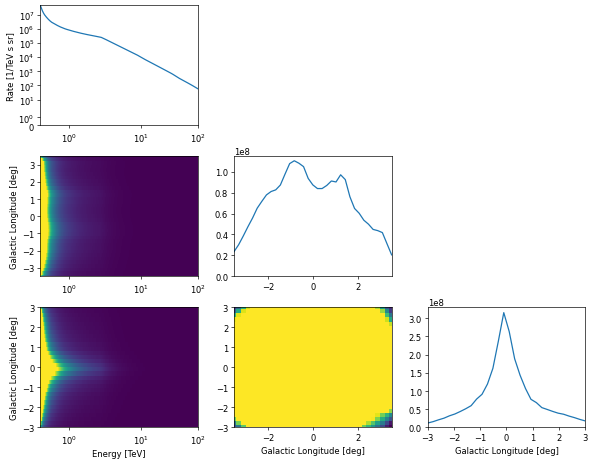

In [16]:
fig,ax = logdensity_matrix_plot(axes=[energy_true_axis, longitudeaxistrue, latitudeaxistrue], 
                        log_dist_matrix=np.log(diffuse_source_map),
                        axis_names=['Energy [TeV]', 'Galactic Longitude [deg]', 'Galactic Longitude [deg]'], 
                        norm=None, vmax=1e6,
                        single_dim_yscales='linear', single_dim_ylabel = 'Rate [1/TeV s sr]', figsize=(10,8), dpi=60)
ax[0,0].set_yscale('symlog')
ax[0,0].set_xscale('symlog')
ax[1,0].set_xscale('symlog')
ax[2,0].set_xscale('symlog')
plt.tight_layout()
plt.show()

### `construct_log_fermi_gaggero_bkg`

From there we also have in in-built interpolator for this map.

In [9]:
log_diffuse_source_interpolator = astro_sources.construct_log_fermi_gaggero_bkg(energy_axis=energy_true_axis, 
                            longitudeaxis=longitudeaxistrue, 
                            latitudeaxis=latitudeaxistrue, 
                            log_aeff=log_aeff, normalise=False)

And we can see the log of the flux for 1 TeV at the Galactic Centre by writing,

In [10]:
log_diffuse_source_interpolator(1.0, 0.0, 0.0)

11.443983420187893

Or log probability using the below.

In [11]:
log_diffuse_source_interpolator = astro_sources.construct_log_fermi_gaggero_bkg(energy_axis=energy_true_axis, 
                            longitudeaxis=longitudeaxistrue, 
                            latitudeaxis=latitudeaxistrue, 
                            log_aeff=log_aeff, normalise=True)
log_diffuse_source_interpolator(1.0, 0.0, 0.0)

-8.608130179892557